In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataset_1D import ECG1DDataset
from QAT_ResNet18 import ResNet18_1D_QAT, fuse_model
import torch.quantization as quant
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from torch.serialization import safe_globals
from torch.serialization import add_safe_globals
import torch.ao.nn.quantized as nnq  # quan trọng!
from torch.nn.quantized import Quantize, DeQuantize
import torch.serialization
from torch.ao.nn.intrinsic.quantized import ConvReLU1d
from torch.nn import Identity
from torch.nn.quantized import FloatFunctional
from torch.quantization import QuantStub, DeQuantStub
from torch.ao.nn.intrinsic.quantized import ConvReLU1d
from QAT_ResNet18 import ResNet18_1D_QAT, BasicBlock1D
from torch.ao.nn.quantized import Quantize
from torch.nn import Identity, MaxPool1d
from torch.nn import Sequential  # Thêm import này
from torch.ao.nn.quantized.modules.conv import Conv1d as QConv1d
from torch.ao.nn.quantized.modules.functional_modules import QFunctional
from torch.nn import BatchNorm1d , AdaptiveAvgPool1d #
from torch.ao.nn.quantized.modules.linear import Linear as QLinear, LinearPackedParams
from torch._C import ScriptObject

# Hyperparameters
batch_size = 32
#  Phải ép về CPU khi load model quantized (vì convert xong chỉ chạy được CPU).
device = torch.device('cpu')  # QAT quantized model chỉ chạy trên CPU

# Load Test Data
test_dataset = ECG1DDataset(root_dir="E:/pv/WORKING/ECG_main_folder/ECG_Classification_MI_detect/data/preprocessed_MI_1D/test")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ResNet18_1D_QAT(num_classes=2)
model.eval()
fuse_model(model)
model.train()
model.qconfig = quant.get_default_qat_qconfig('fbgemm')
quant.prepare_qat(model, inplace=True)
model.eval()
quantized_model = quant.convert(model, inplace=False)  # Convert xong mới load state_dict int8

# Load int8 state_dict
checkpoint = torch.load("E:/pv/WORKING/ECG_main_folder/ECG_Classification_MI_detect/models/ResNet18_QAT.pth", map_location=device)
quantized_model.load_state_dict(checkpoint)
quantized_model.eval()

e:\pv\WORKING\ECG_main_folder\ecg_env\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
e:\pv\WORKING\ECG_main_folder\ecg_env\Lib\site-packages\torch\ao\quantization\utils.py:408: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


ResNet18_1D_QAT(
  (quant): Quantize(scale=tensor([0.1507]), zero_point=tensor([64]), dtype=torch.quint8)
  (conv1): QuantizedConv1d(12, 64, kernel_size=(7,), stride=(2,), scale=0.16915547847747803, zero_point=60, padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock1D(
      (conv1): QuantizedConvReLU1d(64, 64, kernel_size=(3,), stride=(1,), scale=0.09214109927415848, zero_point=0, padding=(1,))
      (bn1): Identity()
      (relu): Identity()
      (conv2): QuantizedConv1d(64, 64, kernel_size=(3,), stride=(1,), scale=0.1525345742702484, zero_point=56, padding=(1,))
      (bn2): Identity()
      (add): QFunctional(
        scale=0.1967959851026535, zero_point=65
        (activation_post_process): Identity()
      )
    )
    (1): BasicBlock1D(
      (conv1): Quantize

In [12]:
import torch
from QAT_ResNet18 import ResNet18_1D_QAT, fuse_model
import torch.quantization as quant
import torch.nn as nn

# ======== 3. Thống kê số lượng tham số ========
total_params = sum(p.numel() for p in quantized_model.parameters())
trainable_params = sum(p.numel() for p in quantized_model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")


Total Parameters: 128
Trainable Parameters: 128


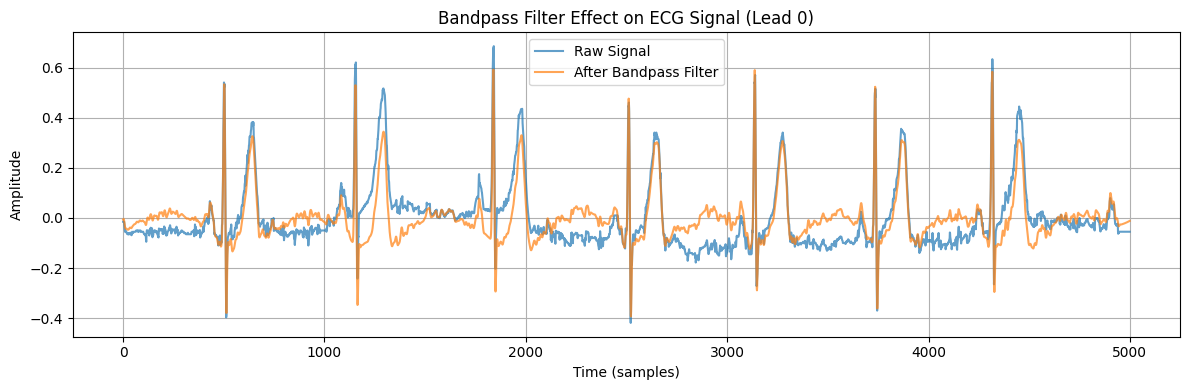

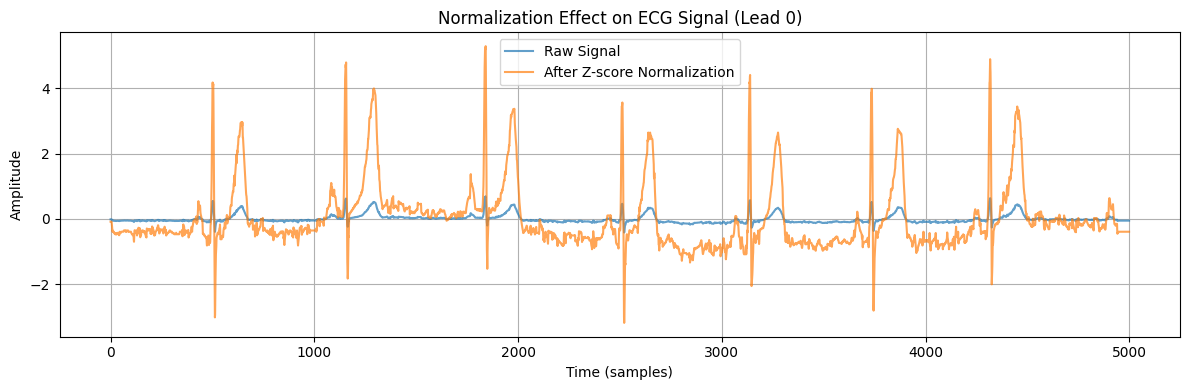

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ======== Bandpass filter (Butterworth) ========
def butter_bandpass_filter(signal, lowcut=1.0, highcut=45.0, fs=500, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# ======== Z-score normalization ========
def z_score_norm(signal):
    return (signal - np.mean(signal)) / (np.std(signal) + 1e-8)

# ======== Load file và vẽ ========
def visualize_ecg_processing(npy_file_path, lead=0):
    # Load tín hiệu
    ecg = np.load(npy_file_path)   # shape: (12, 4096)
    raw_signal = ecg[lead, :]      # lấy 1 lead để vẽ

    # Filter
    filtered_signal = butter_bandpass_filter(raw_signal)

    # Normalization
    normalized_signal = z_score_norm(raw_signal)

    # --------- Hình 1: Raw vs Filtered ----------
    plt.figure(figsize=(12, 4))
    plt.plot(raw_signal, label='Raw Signal', alpha=0.7)
    plt.plot(filtered_signal, label='After Bandpass Filter', alpha=0.7)
    plt.title(f'Bandpass Filter Effect on ECG Signal (Lead {lead})')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --------- Hình 2: Raw vs Normalized ----------
    plt.figure(figsize=(12, 4))
    plt.plot(raw_signal, label='Raw Signal', alpha=0.7)
    plt.plot(normalized_signal, label='After Z-score Normalization', alpha=0.7)
    plt.title(f'Normalization Effect on ECG Signal (Lead {lead})')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ==================== Run ====================
# Ví dụ dùng:
npy_path = 'E:/pv/WORKING/ECG_main_folder/ECG_Classification_MI_detect/data/loaded_data_MI/NORM/record_2.npy'
visualize_ecg_processing(npy_path, lead=0)  # bạn có thể thay lead từ 0 đến 11


Saving records: 100%|██████████| 9268/9268 [03:49<00:00, 40.35it/s]  



✅ Saved processed data to: E:/pv/WORKING/ECG_main_folder/ECG_Classification_MI_detect/data/loaded_data_MI/
📊 MI samples  : 4134
📊 NORM samples: 5134


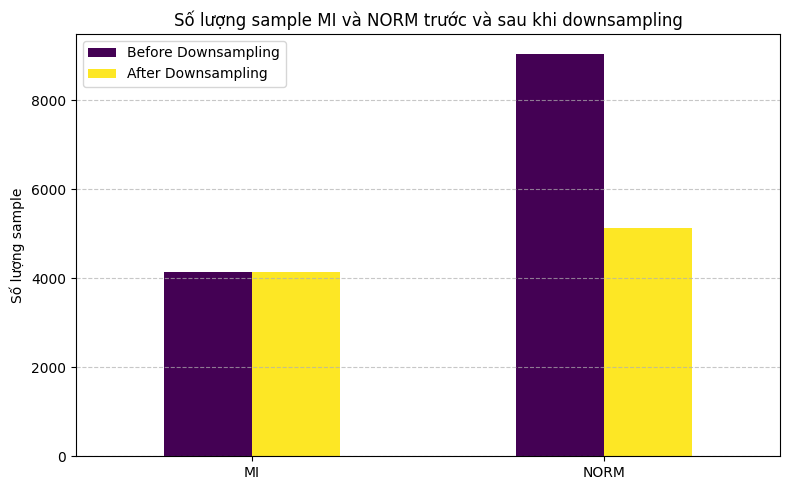

In [8]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import resample

# ========== Đường dẫn ==========
raw_data_path = 'E:/pv/WORKING/ECG_main_folder/ECG_Classification_MI_detect/data/raw_data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
save_path = 'E:/pv/WORKING/ECG_main_folder/ECG_Classification_MI_detect/data/loaded_data_MI/'
os.makedirs(save_path, exist_ok=True)

# Sampling rate 500Hz
sampling_rate = 500

# Tạo thư mục MI và NORM
mi_path = os.path.join(save_path, 'MI')
norm_path = os.path.join(save_path, 'NORM')
os.makedirs(mi_path, exist_ok=True)
os.makedirs(norm_path, exist_ok=True)

# ========== Đọc và xử lý label ==========
def aggregate_diagnostic(y_dict, agg_df, weight_threshold=50):
    tmp = []
    for key, value in y_dict.items():
        if value >= weight_threshold and key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Load metadata
Y = pd.read_csv(os.path.join(raw_data_path, 'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

agg_df = pd.read_csv(os.path.join(raw_data_path, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

Y['diagnostic_superclass'] = Y.scp_codes.apply(lambda x: aggregate_diagnostic(x, agg_df))

# Loại các record không có label
Y = Y[Y['diagnostic_superclass'].apply(lambda x: len(x) > 0)].copy()

# Loại record có cả NORM và bệnh
def is_mixed_with_norm(labels):
    return 'NORM' in labels and any(label != 'NORM' for label in labels)

Y = Y[~Y['diagnostic_superclass'].apply(is_mixed_with_norm)].copy()

# Chỉ giữ lại MI và NORM
def keep_only_mi_norm(labels):
    if 'MI' in labels:
        return 'MI'
    elif 'NORM' in labels:
        return 'NORM'
    else:
        return None

Y['target'] = Y['diagnostic_superclass'].apply(keep_only_mi_norm)
Y = Y[Y['target'].notnull()].copy()

# Cập nhật đường dẫn file
if sampling_rate == 100:
    Y['filepath'] = Y['filename_lr']
else:
    Y['filepath'] = Y['filename_hr']

# ========== Phân tích số lượng trước khi downsampling ==========
Y_mi = Y[Y['target'] == 'MI']
Y_norm = Y[Y['target'] == 'NORM']

# ========== Downsampling class NORM ==========
Y_norm_downsampled = resample(
    Y_norm,
    replace=False,
    n_samples=len(Y_mi) + 1000,  # Cho NORM chỉ nhiều hơn MI một chút
    random_state=4
)

# Gộp lại tập balanced
Y_balanced = pd.concat([Y_mi, Y_norm_downsampled])

# ========== Lưu dữ liệu vào thư mục MI/NORM ==========
count_mi = 0
count_norm = 0

for ecg_id, row in tqdm(Y_balanced.iterrows(), total=Y_balanced.shape[0], desc="Saving records"):
    filepath = os.path.join(raw_data_path, row['filepath'])
    signal, _ = wfdb.rdsamp(filepath)
    signal = signal.T  # Transpose về (12, 5000)
    signal = signal.astype(np.float32)

    if row['target'] == 'MI':
        np.save(os.path.join(mi_path, f'record_{ecg_id}.npy'), signal)
        count_mi += 1
    elif row['target'] == 'NORM':
        np.save(os.path.join(norm_path, f'record_{ecg_id}.npy'), signal)
        count_norm += 1

# Lưu lại DataFrame gốc
with open(os.path.join(save_path, 'Y.pkl'), 'wb') as f:
    pickle.dump(Y, f)

print(f"\n✅ Saved processed data to: {save_path}")
print(f"📊 MI samples  : {count_mi}")
print(f"📊 NORM samples: {count_norm}")

# ========== Vẽ biểu đồ số lượng MI/NORM trước và sau downsampling ==========
original_counts = {'MI': len(Y_mi), 'NORM': len(Y_norm)}
after_downsampling = {'MI': len(Y_mi), 'NORM': len(Y_norm_downsampled)}

df_bar = pd.DataFrame({
    'Before Downsampling': original_counts,
    'After Downsampling': after_downsampling
})

df_bar.plot(kind='bar', figsize=(8, 5), colormap='viridis')
plt.title('Số lượng sample MI và NORM trước và sau khi downsampling')
plt.ylabel('Số lượng sample')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Nếu muốn lưu ảnh:
# plt.savefig(os.path.join(save_path, 'class_distribution_comparison.png'))

plt.show()
